<a href="https://colab.research.google.com/github/Gagan-K-Shetty/Da_project/blob/master/Hospital_readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




Hospital readmission measures have been touted not only as a quality measure, but also as a means to bend the healthcare cost curve. In the United States, hospital readmissions within a span of 30 days turn out to be an immense burden on the healthcare system and the patient's lifestyle.<br><br>
A USFC study in the US shows that 27% of readmissions are potentially avoidable through better diagnosis at discharge or having a predictive mechanism to evaluate the chance of a patient being readmitted based on various factors. The cost per readmission in the US varies from 10 to 14 thousand dollars, subject to the insurance plan, medical facilities utilized etc.<br><br>
For this purpose, we intend to perform data analytics on the electronic health records of patients and determine the main indicators of hospital readmission and predict the chances of readmission in the future for the current patients.

### The rest of the notebook contains the project ordered as follows :-
<ol>
    <li><a href='#Research_goal'> Setting the research goal </a></li>
    <li><a href='#Retrieving_data'> Retrieving data </a></li>
    <li><a href='#Data_preparation'> Data preparation </a></li>
    <li><a href='#Data_exploration'> Data exploration </a></li>
    <li><a href='#Data_modeling'> Data modeling </a></li> 
    <li><a href='#Presentation'> Presentation and automation </a></li>
</ol>

<a id='Research_goal'></a>
# Setting the research goal


The main aim of this project to **predict the chances of readmission of a patient**. Using the electronic health records, we can identify the main indicators of hospital readmissions and flag the patients at high risk of readmission to the hospital. The scope of this project is limited to identifying readmission scenarios in to cases :-
<ol>
    <li> Readmission within 1 months </li>
    <li> Readmission within 6 months</li>
</ol>
The main advantages of this project:-
  * **Patient comfort** - By reducing the number of readmissions, we can improve the lives of patients and reduce the repeated time they spend in hospital by targeting the problems at an earlier stage.
  * **Hospital burden** - By reducing the number of readmissions, we can reduce the burden on the healthcare system by potentially treating the diseases at an earlier stage and reduce the number of patients overburdening the hospital(atleast the one which could be avoided)
  * **Cost factor** - By reducing the number of readmissions, we can reduce the cost associated with healthcare, which is a burden on both the patients and the insurance companies.

<a id='Retrieving_data'></a>
# Retrieving the data


Since the aim of the project is to reduce the readmission of patients, we need data of the patients while they are admitted in the hospital. Many hospitals maintain records of patients. These records are called Electronic Health Records(EHR).<br> For the purpose of the project, we looked for publicly available EHR datasets to work on. After researching on the data sets available, we found the MIMIC-III dataset to be the best choice for our project.<br><br>
<a href='https://www.nature.com/articles/sdata201635'>MIMIC-III</a> is an openly available dataset developed by the MIT Lab for Computational Physiology, comprising deidentified health data associated with ~40,000 critical care patients. It includes demographics, vital signs, laboratory tests, medications, and more.
<a href='https://mit-lcp.github.io/mimic-schema-spy'/>Click here</a> for a detailed schema of the database.<br>
After some research, we decided to use the following tables from the database:-
   * **patients** : Contains patients associated with an admission to the ICU
   * **admissions** : Contains the hospital admissions associated with an ICU stay.
   * **diagnoses** : Contains diagnoses relating to a hospital admission coded using the ICD9 system.
   * **drgCodes** : Hospital stays classified using the Diagnosis-Related Group system.
   * **icuStays** : List of ICU admissions.
   * **procedures** : Procedures relating to a hospital admission coded using the ICD9 system.
   * **prescriptions** : Contains a list of the medicines prescribed 
   * **dIcdDiagnoses** : Dictionary of the International Classification of Diseases, 9th Revision (Diagnoses).
   * **dIcdProcedures** : Dictionary of the International Classification of Diseases, 9th Revision (Procedures).
   
For this project we pulled records(maximum of 50k records) from each of these tables. The contents of the tables are described in the next step.

Since we are using google colab, we need some boiler plate code to load the data stored in the google drive:-

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import dill

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
folder_id = '19W1TgqRQqPxTxCCb1hGR1QhGajSjSs01'
listed = drive.ListFile({'q': "title contains '.csv' and '"+folder_id+"' in parents"}).GetList()
files = []
for file in listed:
  #print('title {}, id {}'.format(file['title'], file['id']))
  files.append({'title' : file['title'], 'id' : file['id']})
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except :
  pass
dataset = {}
for x in files:
  output_file = os.path.join(download_path, x['title'])
  temp_file = drive.CreateFile({'id': x['id']})
  temp_file.GetContentFile(output_file)
  data = pd.read_csv(output_file)
  #print(data)
  dataset[x['title']] = data
print("Table names are",", ".join(dataset.keys()))
print()

Table names are admissions.csv, procedures.csv, icuStays.csv, drgCodes.csv, diagnoses.csv, patients.csv, prescriptions.csv, dIcdDiagnoses.csv, dIcdProcedures.csv



<a id='Data_preparation'></a>
# Data Preparation

In this step, we perform the standard data cleaning and transformation steps. Let’s take a look at each table one by one. First lets load the requied libraries

In [0]:
import numpy as np

## Admissions


Admissions table contains the following columns: -
   * **row_id** : Unique row identifier.
   * **subject_id** : Foreign key. Identifies the patient.
   * **hadm_id**	: Primary key. Identifies the hospital stay.
   * **admittime**	:	Time of admission to the hospital.
   * **dischtime** :	Time of discharge from the hospital.
   * **deathtime** : Time of death.
   * **admission_type** : Type of admission, for example emergency or elective.
   * **admission_location** : Admission location.
   * **discharge_location** : Discharge location
   * **insurance**	:	Insurance type.
   * **language** :	Language.
   * **religion** :	Religon.
   * **marital_status** : Marital status.
   * **ethnicity** : Ethnicity.
   * **edregtime** : Metadata was un available for this variable
   * **edouttime** : Metadata was un available for this variable
   * **diagnosis** : Diagnosis.
   * **hospital_expire_flag** : Metadata was un available for this variable
   * **has_chartevents_data** : Hospital admission has at least one observation in the CHARTEVENTS table.<br>
Let's take a look at the actual contents of the table admissions.

In [5]:
admissions = dataset["admissions.csv"]
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
admissions

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09T12:26:00.000Z,NaN,BENZODIAZEPINE OVERDOSE,DISC-TRAN CANCER/CHLDRN H,2196-04-10T15:54:00.000Z,2196-04-09T13:24:00.000Z,2196-04-09T10:06:00.000Z,WHITE,165315,1,0,Private,NaN,MARRIED,UNOBTAINABLE,21,22
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03T07:15:00.000Z,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,2153-09-08T19:10:00.000Z,NaN,NaN,WHITE,152223,1,0,Medicare,NaN,MARRIED,CATHOLIC,22,23
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18T19:34:00.000Z,NaN,BRAIN MASS,HOME HEALTH CARE,2157-10-25T14:00:00.000Z,NaN,NaN,WHITE,124321,1,0,Medicare,ENGL,MARRIED,CATHOLIC,23,23
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06T16:14:00.000Z,NaN,INTERIOR MYOCARDIAL INFARCTION,HOME,2139-06-09T12:48:00.000Z,NaN,NaN,WHITE,161859,1,0,Private,NaN,SINGLE,PROTESTANT QUAKER,24,24
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02T02:06:00.000Z,NaN,ACUTE CORONARY SYNDROME,HOME,2160-11-05T14:55:00.000Z,2160-11-02T04:27:00.000Z,2160-11-02T01:01:00.000Z,WHITE,129635,1,0,Private,NaN,MARRIED,UNOBTAINABLE,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30T21:13:00.000Z,NaN,TRAUMA,HOME,2131-04-02T15:02:00.000Z,2131-03-30T22:41:00.000Z,2131-03-30T19:44:00.000Z,WHITE,191113,1,0,Private,ENGL,SINGLE,NOT SPECIFIED,58594,98800
58972,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05T20:00:00.000Z,2151-03-06T09:10:00.000Z,SAH,DEAD/EXPIRED,2151-03-06T09:10:00.000Z,2151-03-05T21:06:00.000Z,2151-03-05T17:23:00.000Z,WHITE,101071,1,1,Medicare,ENGL,WIDOWED,CATHOLIC,58595,98802
58973,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2200-09-12T07:15:00.000Z,NaN,RENAL CANCER/SDA,HOME HEALTH CARE,2200-09-20T12:08:00.000Z,NaN,NaN,WHITE,122631,1,0,Private,ENGL,MARRIED,NOT SPECIFIED,58596,98805
58974,EMERGENCY ROOM ADMIT,EMERGENCY,2128-11-11T02:29:00.000Z,NaN,S/P FALL,SNF,2128-12-22T13:11:00.000Z,2128-11-11T03:16:00.000Z,2128-11-10T23:48:00.000Z,WHITE,170407,0,0,Private,ENGL,MARRIED,CATHOLIC,58597,98813


Now that we have an idea of the contents of the table, lets take a look at the summary statistics

In [6]:
admissions.describe(include = [np.number])

,hadm_id,has_chartevents_data,hospital_expire_flag,row_id,subject_id
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,149970.809584,0.973006,0.099261,29488.500000,33755.583288
std,28883.095213,0.162067,0.299014,17025.049075,28092.726225
min,100001.000000,0.000000,0.000000,1.000000,2.000000
25%,124952.750000,1.000000,0.000000,14744.750000,11993.750000
50%,149989.500000,1.000000,0.000000,29488.500000,24133.500000
75%,174966.500000,1.000000,0.000000,44232.250000,53851.500000
max,199999.000000,1.000000,1.000000,58976.000000,99999.000000


The above output show the descriptive stastics of the numerical data. However, most of the numeric columns are primary keys and foreign keys. Let's take a look at the categorical data.

In [7]:
admissions.describe(include = ['O'])

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,insurance,language,marital_status,religion
count,58976,58976,58976,5854,58951,58976,58976,30877,30877,58976,58976,33644,48848,58518
unique,9,4,58651,5834,15691,17,58657,30864,30874,41,5,75,7,20
top,EMERGENCY ROOM ADMIT,EMERGENCY,2105-02-09T07:15:00.000Z,2177-08-16T12:00:00.000Z,NEWBORN,HOME,2129-11-19T15:00:00.000Z,2188-08-05T20:55:00.000Z,2132-10-26T20:31:00.000Z,WHITE,Medicare,ENGL,MARRIED,CATHOLIC
freq,22754,42071,4,2,7823,18962,3,2,2,40996,28215,29086,24239,20606


The above cell describes the categorical data

One thing we might notice is that the time variables are in a different format. So lets go ahead and fix that:-

In [8]:
admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.admittime.head()

0   2196-04-09 12:26:00
1   2153-09-03 07:15:00
2   2157-10-18 19:34:00
3   2139-06-06 16:14:00
4   2160-11-02 02:06:00
Name: admittime, dtype: datetime64[ns]

You might have noticed that according to the admission date, admission events occured between 2100 to 2200 even though the events actually occured between 2001 and 2012. The reason for this is that before data was incorporated into the MIMIC-III database, it was first deidentified in accordance with Health Insurance Portability and Accountability Act (HIPAA) standards using structured data cleansing and date shifting. The deidentification process for structured data required the removal of all eighteen of the identifying data elements listed in HIPAA, including fields such as patient name, telephone number, address, and dates. In particular, dates were shifted into the future by a random offset for each individual patient in a consistent manner to preserve intervals, resulting in stays which occur sometime between the years 2100 and 2200. Time of day, day of the week, and approximate seasonality were conserved during date shifting. Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years. Since the intervals are preserved, this won’t create any issues as we are interested in the differences in the times(lenght of stay, age, readmission, etc) Lets go ahead and convert the remaining dates as well.

In [0]:
admissions.dischtime = pd.to_datetime(admissions.dischtime)
admissions.edouttime = pd.to_datetime(admissions.edouttime)
admissions.edregtime = pd.to_datetime(admissions.edregtime)
admissions.deathtime = pd.to_datetime(admissions.deathtime)

Now that we have all the data in the expected format, lets look at the categorical data. Consider religion

In [10]:
pd.set_option('display.max_rows', 30)
admissions.religion.value_counts(dropna=False)

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
NaN                         458
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: religion, dtype: int64

Based on the statistics above, we can notice that several religions such as LUTHERAN, METHODIST, etc are a part of very few number of records (when compared to 50k records). We can merge these into the "OTHER" category as we cannot extract any meaningful information considering the paucity of records. Furthermore, "NOT SPECIFIED" and "UNOBTAINABLE" basically mean the same. NaN can be merged into the NOT SPECIFIED category as NaN indicates a problem in recording the data and we can treat it as an unobtainable value. Another thing to consider is that religions such as CATHOLIC, EPISCOPALIAN, etc are all various forms of Christian denominations. 
For the grouping of the religions, first we shall group similar religions(eg : different forms of christian denominations), then we shall group the religions with less than atleast 1000 records into "OTHER".

In [11]:
admissions.religion = admissions.religion.str.replace("|".join(["CATHOLIC","PROTESTANT QUAKER","EPISCOPALIAN","GREEK ORTHODOX","CHRISTIAN SCIENTIST","JEHOVAH'S WITNESS","UNITARIAN-UNIVERSALIST","ROMANIAN EAST. ORTH","7TH DAY ADVENTIST","BAPTIST","METHODIST"]),"CHRISTIAN")
admissions.religion = admissions.religion.str.replace("UNOBTAINABLE","NOT SPECIFIED")
admissions.religion = admissions.religion.fillna(value="NOT SPECIFIED")
values_less_than_thousand = admissions.religion.value_counts()[admissions.religion.value_counts()<1000]
admissions.religion = admissions.religion.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.religion.value_counts()

CHRISTIAN        29864
NOT SPECIFIED    20480
JEWISH            5314
OTHER             3318
Name: religion, dtype: int64

Now, the number of religions have been reduced to 4, which makes it easier to work with and there is minimal loss of information

Let's move on to maritial status

In [12]:
admissions.marital_status.value_counts()

MARRIED              24239
SINGLE               13254
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: marital_status, dtype: int64

Let's take a look at the contents of the language column

In [13]:
admissions.language.value_counts(dropna=False)

ENGL    29086
NaN     25332
SPAN     1083
RUSS      790
PTUN      628
CANT      413
PORT      342
CAPE      256
MAND      156
HAIT      150
ITAL      124
VIET       94
GREE       75
ARAB       47
PERS       44
        ...  
*YOR        1
*BOS        1
*FAR        1
* FU        1
*FIL        1
*TAM        1
*SPA        1
GERM        1
*CRE        1
** T        1
*PHI        1
*LIT        1
*ARA        1
*DEA        1
*ROM        1
Name: language, Length: 76, dtype: int64

As we can see, majority of the patients are english speaking and the values have not been recorded for many people(25252 NaN values!). This column does not provide enough confidence to the target variable considering the nuber of NaN values. However, we will still keep this column and decided to use it or not in the data exploration and model building phase. For now, we can group all the languages which have less than 100 records into one group and also call NaN as unobtainable.

In [14]:
admissions.language = admissions.language.fillna("Unobtainable")
values_less_than_hundred = admissions.language.value_counts()[admissions.language.value_counts()<100]
values_less_than_hundred = [x.replace("*","\*") for x in values_less_than_hundred.index]
values_less_than_hundred
admissions.language = admissions.language.str.replace("|".join(values_less_than_hundred),"OTHER")
admissions.language.value_counts()

ENGL            29086
Unobtainable    25332
SPAN             1083
RUSS              790
PTUN              628
OTHER             616
CANT              413
PORT              342
CAPE              256
MAND              156
HAIT              150
ITAL              124
Name: language, dtype: int64

When it comes to medical bills, insurance plays a major role in it. Let's take a look at the insurance column

In [15]:
admissions.insurance.value_counts(dropna=False)

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: insurance, dtype: int64

Insurance seems to have no issues with respect to the integrity of the data

Next, ethnicity:-

In [16]:
admissions.ethnicity.value_counts(dropna=False)

WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
          

As we can see, the ethnicity of the patientis vary a lot and there are many ethnicities with very little records, which can give less information. We can collapse all the sub categories of asian, white, hispanic, etc into their parent category. Furthermore, we can group all ethnicities with records less than 1000 to the others category as due to the paucity of records, they will not provide much information anyways

In [17]:
admissions.loc[admissions.ethnicity.str.contains("ASIAN"),"ethnicity"] = 'ASIAN'
admissions.loc[admissions.ethnicity.str.contains("HISPANIC"),"ethnicity"] = 'HISPANIC'
admissions.loc[admissions.ethnicity.str.contains("WHITE"),"ethnicity"] = 'WHITE'
values_less_than_thousand = admissions.ethnicity.value_counts()[admissions.ethnicity.value_counts()<1000]
admissions.ethnicity = admissions.ethnicity.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.loc[admissions.ethnicity.str.contains("OTHER"),"ethnicity"] = 'OTHER'
admissions.ethnicity.value_counts()

WHITE                    41325
OTHER                     8993
UNKNOWN/NOT SPECIFIED     4523
HISPANIC                  2128
ASIAN                     2007
Name: ethnicity, dtype: int64

Similarly for discharge location:-

In [18]:
admissions.discharge_location.value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: discharge_location, dtype: int64

We can group all the locations with number of records less than 1000 as others.

In [19]:
values_less_than_thousand = admissions.discharge_location.value_counts()[admissions.discharge_location.value_counts()<1000]
admissions.discharge_location = admissions.discharge_location.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.discharge_location.value_counts()

HOME                        18962
HOME HEALTH CARE            13963
SNF                          7705
REHAB/DISTINCT PART HOSP     6429
DEAD/EXPIRED                 5854
LONG TERM CARE HOSPITAL      2305
OTHER                        2224
SHORT TERM HOSPITAL          1534
Name: discharge_location, dtype: int64

In [20]:
admissions.loc[admissions.admission_location.str.contains("INFO"),"admission_location"] = "OTHER"
values_less_than_thousand = admissions.admission_location.value_counts()[admissions.admission_location.value_counts()<1000]
admissions.admission_location = admissions.admission_location.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.admission_location.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
OTHER                          655
Name: admission_location, dtype: int64

In [21]:
admissions.admission_type.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64

And finally diagnosis.

In [22]:
admissions.diagnosis.value_counts()

NEWBORN                                                              7823
PNEUMONIA                                                            1566
SEPSIS                                                               1184
CONGESTIVE HEART FAILURE                                              928
CORONARY ARTERY DISEASE                                               840
CHEST PAIN                                                            778
INTRACRANIAL HEMORRHAGE                                               713
ALTERED MENTAL STATUS                                                 712
GASTROINTESTINAL BLEED                                                686
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA             583
UPPER GI BLEED                                                        580
ABDOMINAL PAIN                                                        554
FEVER                                                                 510
DIABETIC KETOACIDOSIS                 

Diagnosis are also available in the icd9 format.The International Classification of Diseases, Ninth Revision, Clinical Modification (ICD-9-CM) is the U.S. health system's adaptation of international ICD-9 standard list of six-character alphanumeric codes to describe diagnoses. This code is formatted in such a way that we can easily group the diagnosis based on the hirarchy. We will discuss more on this part later when we are done cleaning the other tables.

The final admissions table is as follows:-

In [23]:
pd.set_option('display.max_rows', 10)
admissions

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,NaT,BENZODIAZEPINE OVERDOSE,OTHER,2196-04-10 15:54:00,2196-04-09 13:24:00,2196-04-09 10:06:00,WHITE,165315,1,0,Private,Unobtainable,MARRIED,NOT SPECIFIED,21,22
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,2153-09-08 19:10:00,NaT,NaT,WHITE,152223,1,0,Medicare,Unobtainable,MARRIED,CHRISTIAN,22,23
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,NaT,BRAIN MASS,HOME HEALTH CARE,2157-10-25 14:00:00,NaT,NaT,WHITE,124321,1,0,Medicare,ENGL,MARRIED,CHRISTIAN,23,23
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,NaT,INTERIOR MYOCARDIAL INFARCTION,HOME,2139-06-09 12:48:00,NaT,NaT,WHITE,161859,1,0,Private,Unobtainable,SINGLE,CHRISTIAN,24,24
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,NaT,ACUTE CORONARY SYNDROME,HOME,2160-11-05 14:55:00,2160-11-02 04:27:00,2160-11-02 01:01:00,WHITE,129635,1,0,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30 21:13:00,NaT,TRAUMA,HOME,2131-04-02 15:02:00,2131-03-30 22:41:00,2131-03-30 19:44:00,WHITE,191113,1,0,Private,ENGL,SINGLE,NOT SPECIFIED,58594,98800
58972,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05 20:00:00,2151-03-06 09:10:00,SAH,DEAD/EXPIRED,2151-03-06 09:10:00,2151-03-05 21:06:00,2151-03-05 17:23:00,WHITE,101071,1,1,Medicare,ENGL,WIDOWED,CHRISTIAN,58595,98802
58973,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2200-09-12 07:15:00,NaT,RENAL CANCER/SDA,HOME HEALTH CARE,2200-09-20 12:08:00,NaT,NaT,WHITE,122631,1,0,Private,ENGL,MARRIED,NOT SPECIFIED,58596,98805
58974,EMERGENCY ROOM ADMIT,EMERGENCY,2128-11-11 02:29:00,NaT,S/P FALL,SNF,2128-12-22 13:11:00,2128-11-11 03:16:00,2128-11-10 23:48:00,WHITE,170407,0,0,Private,ENGL,MARRIED,CHRISTIAN,58597,98813


## Prescriptions

The Prescriptions table contains the following:-
   * **row_id** : Unique row identifier.
   * **subject_id**	: Foreign key. Identifies the patient.
   * **hadm_id** : Foreign key. Identifies the hospital stay.
   * **icustay_id**	: Foreign key. Identifies the ICU stay.
   * **startdate** : Date when the prescription started.
   * **enddate** : Date when the prescription ended.
   * **drug_type** : Type of drug.
   * **drug** : Name of the drug.
   * **drug_name_poe** : Name of the drug on the Provider Order Entry interface.
   * **drug_name_generic** : Generic drug name.
   * **formulary_drug_cd** : Formulary drug code.
   * **gsn** : Generic Sequence Number.
   * **ndc** : National Drug Code.
   * **prod_strength** : Strength of the drug (product).
   * **dose_val_rx** : Dose of the drug prescribed.
   * **dose_unit_rx** : Unit of measurement associated with the dose.
   * **form_val_disp** : Amount of the formulation dispensed.
   * **form_unit_disp** : Unit of measurement associated with the formulation.
   * **route** : Route of administration, for example intravenous or oral.
<br>
Let's take a look at the actual contents of the table prescriptions

In [24]:
prescriptions = dataset["prescriptions.csv"]
prescriptions

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14T00:00:00.000Z,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13T00:00:00.000Z,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14T00:00:00.000Z,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13T00:00:00.000Z,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14T00:00:00.000Z,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13T00:00:00.000Z,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14T00:00:00.000Z,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13T00:00:00.000Z,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14T00:00:00.000Z,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13T00:00:00.000Z,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,mg,0.125,Digoxin,Digoxin,Digoxin,MAIN,2177-10-20T00:00:00.000Z,TAB,1,DIGO125,000018,166385,NaN,1.730243e+08,0.125mg Tab,PO,2073458,2177-10-17T00:00:00.000Z,1348
49996,mg,12.5,Metoprolol,Metoprolol,Metoprolol,MAIN,2177-10-20T00:00:00.000Z,TAB,0.25,METO50,005132,166385,NaN,6.258408e+10,50MG TAB,PO,2073457,2177-10-17T00:00:00.000Z,1348
49997,mg,325,Aspirin,Aspirin,Aspirin,MAIN,2177-10-20T00:00:00.000Z,TAB,1,ASA325,004376,166385,NaN,5.107900e+10,325mg Tab,PO,2073456,2177-10-17T00:00:00.000Z,1348
49998,in,1,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,MAIN,2177-10-20T00:00:00.000Z,TUBE,0.01,NTG2O,000464,166385,NaN,5.456934e+10,30g Tube,TP,2073455,2177-10-17T00:00:00.000Z,1348


Let's clean up the data formats, mainly, the dates.

In [0]:
prescriptions.enddate = pd.to_datetime(prescriptions.enddate)
prescriptions.startdate = pd.to_datetime(prescriptions.startdate)

The prescriptions is finally as follows:-

In [26]:
prescriptions

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,mg,0.125,Digoxin,Digoxin,Digoxin,MAIN,2177-10-20,TAB,1,DIGO125,000018,166385,NaN,1.730243e+08,0.125mg Tab,PO,2073458,2177-10-17,1348
49996,mg,12.5,Metoprolol,Metoprolol,Metoprolol,MAIN,2177-10-20,TAB,0.25,METO50,005132,166385,NaN,6.258408e+10,50MG TAB,PO,2073457,2177-10-17,1348
49997,mg,325,Aspirin,Aspirin,Aspirin,MAIN,2177-10-20,TAB,1,ASA325,004376,166385,NaN,5.107900e+10,325mg Tab,PO,2073456,2177-10-17,1348
49998,in,1,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,MAIN,2177-10-20,TUBE,0.01,NTG2O,000464,166385,NaN,5.456934e+10,30g Tube,TP,2073455,2177-10-17,1348


## Patients

The patients table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Primary key. Identifies the patient.
  * **gender** : Gender.
  * **dob** : Date of birth.
  * **dod** : Date of death. Null if the patient was alive at least 90 days post hospital discharge.
  * **dod_hosp** : Date of death recorded in the hospital records.
  * **dod_ssn** : Date of death recorded in the social security records.
  * **expire_flag** : Flag indicating that the patient has died.
  <br>
Let's take a look at the actual contents of the table patients.

In [27]:
patients = dataset["patients.csv"]
patients

,dob,dod,dod_hosp,dod_ssn,expire_flag,gender,row_id,subject_id
0,2075-03-13T00:00:00.000Z,NaN,NaN,NaN,0,F,234,249
1,2164-12-27T00:00:00.000Z,2188-11-22T00:00:00.000Z,2188-11-22T00:00:00.000Z,NaN,1,F,235,250
2,2090-03-15T00:00:00.000Z,NaN,NaN,NaN,0,M,236,251
3,2078-03-06T00:00:00.000Z,NaN,NaN,NaN,0,M,237,252
4,2089-11-26T00:00:00.000Z,NaN,NaN,NaN,0,F,238,253
...,...,...,...,...,...,...,...,...
46515,2026-05-25T00:00:00.000Z,NaN,NaN,NaN,0,M,31840,44089
46516,2124-07-27T00:00:00.000Z,NaN,NaN,NaN,0,F,31841,44115
46517,2049-11-26T00:00:00.000Z,2135-01-12T00:00:00.000Z,2135-01-12T00:00:00.000Z,NaN,1,F,31842,44123
46518,2076-07-25T00:00:00.000Z,NaN,NaN,NaN,0,F,31843,44126


We can bring the dates into the standard formats used in the other tables

In [0]:
patients.dob = pd.to_datetime(patients.dob)
patients.dod = pd.to_datetime(patients.dod)
patients.dod_hosp = pd.to_datetime(patients.dod_hosp)
patients.dod_ssn = pd.to_datetime(patients.dod_ssn)

We can make the genders into male and female instead of M and F for better readability

In [0]:
patients.gender = patients.gender.str.replace("F","female")
patients.gender = patients.gender.str.replace("M","male")

The patients table is finally as follows:-

In [30]:
patients

,dob,dod,dod_hosp,dod_ssn,expire_flag,gender,row_id,subject_id
0,2075-03-13,NaT,NaT,NaT,0,female,234,249
1,2164-12-27,2188-11-22,2188-11-22,NaT,1,female,235,250
2,2090-03-15,NaT,NaT,NaT,0,male,236,251
3,2078-03-06,NaT,NaT,NaT,0,male,237,252
4,2089-11-26,NaT,NaT,NaT,0,female,238,253
...,...,...,...,...,...,...,...,...
46515,2026-05-25,NaT,NaT,NaT,0,male,31840,44089
46516,2124-07-27,NaT,NaT,NaT,0,female,31841,44115
46517,2049-11-26,2135-01-12,2135-01-12,NaT,1,female,31842,44123
46518,2076-07-25,NaT,NaT,NaT,0,female,31843,44126


## Icu stays

The icu stays table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id**	: Foreign key. Identifies the patient.
  * **hadm_id**	: Foreign key. Identifies the hospital stay.
  * **icustay_id** : Primary key. Identifies the ICU stay.
  * **dbsource** : Source database of the item.
  * **first_careunit** : First careunit associated with the ICU stay.
  * **last_careunit** : Last careunit associated with the ICU stay.
  * **first_wardid** : Identifier for the first ward the patient was located in.
  * **last_wardid** : Identifier for the last ward the patient is located in.
  * **intime** : Time of admission to the ICU.
  * **outtime** : Time of discharge from the ICU.
  * **los	float8** : Length of stay in the ICU in fractional days.<br>
  Let's take a look at the actual contents of the table patients.
  

In [31]:
icu_stays = dataset['icuStays.csv']
icu_stays

,dbsource,first_careunit,first_wardid,hadm_id,icustay_id,intime,last_careunit,last_wardid,los,outtime,row_id,subject_id
0,carevue,MICU,52,110404,280836,2198-02-14T23:27:38.000Z,MICU,52,3.2490,2198-02-18T05:26:11.000Z,365,268
1,carevue,MICU,52,106296,206613,2170-11-05T11:05:29.000Z,MICU,52,3.2788,2170-11-08T17:46:57.000Z,366,269
2,carevue,CCU,57,188028,220345,2128-06-24T15:05:20.000Z,CCU,57,2.8939,2128-06-27T12:32:29.000Z,367,270
3,carevue,MICU,52,173727,249196,2120-08-07T23:12:42.000Z,SICU,23,2.0600,2120-08-10T00:39:04.000Z,368,271
4,carevue,CCU,57,164716,210407,2186-12-25T21:08:04.000Z,CCU,57,1.6202,2186-12-27T12:01:13.000Z,369,272
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,metavision,CSRU,15,143774,201233,2104-04-15T10:18:16.000Z,CSRU,15,2.1894,2104-04-17T14:51:00.000Z,59806,94944
61528,metavision,CCU,7,123750,283653,2155-12-08T05:33:16.000Z,CCU,7,2.4942,2155-12-10T17:24:58.000Z,59807,94950
61529,metavision,SICU,57,196881,241585,2160-03-03T16:09:11.000Z,SICU,57,0.9259,2160-03-04T14:22:33.000Z,59808,94953
61530,metavision,CSRU,15,118475,202802,2183-03-25T09:53:10.000Z,CSRU,15,2.3346,2183-03-27T17:55:03.000Z,59809,94954


Performing the standard data formatting procedure for date time formats

In [0]:
icu_stays.intime = pd.to_datetime(icu_stays.intime)
icu_stays.outtime = pd.to_datetime(icu_stays.outtime)

The final icu stays is as follows:-

In [33]:
icu_stays

,dbsource,first_careunit,first_wardid,hadm_id,icustay_id,intime,last_careunit,last_wardid,los,outtime,row_id,subject_id
0,carevue,MICU,52,110404,280836,2198-02-14 23:27:38,MICU,52,3.2490,2198-02-18 05:26:11,365,268
1,carevue,MICU,52,106296,206613,2170-11-05 11:05:29,MICU,52,3.2788,2170-11-08 17:46:57,366,269
2,carevue,CCU,57,188028,220345,2128-06-24 15:05:20,CCU,57,2.8939,2128-06-27 12:32:29,367,270
3,carevue,MICU,52,173727,249196,2120-08-07 23:12:42,SICU,23,2.0600,2120-08-10 00:39:04,368,271
4,carevue,CCU,57,164716,210407,2186-12-25 21:08:04,CCU,57,1.6202,2186-12-27 12:01:13,369,272
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,metavision,CSRU,15,143774,201233,2104-04-15 10:18:16,CSRU,15,2.1894,2104-04-17 14:51:00,59806,94944
61528,metavision,CCU,7,123750,283653,2155-12-08 05:33:16,CCU,7,2.4942,2155-12-10 17:24:58,59807,94950
61529,metavision,SICU,57,196881,241585,2160-03-03 16:09:11,SICU,57,0.9259,2160-03-04 14:22:33,59808,94953
61530,metavision,CSRU,15,118475,202802,2183-03-25 09:53:10,CSRU,15,2.3346,2183-03-27 17:55:03,59809,94954


## Drg codes

The drg codes table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id**	: Foreign key. Identifies the hospital stay.
  * **drg_type** : Type of Diagnosis-Related Group, for example APR is All Patient Refined
  * **drg_code** : Diagnosis-Related Group code
  * **description** : Description of the Diagnosis-Related Group
  * **drg_severity** : Relative severity, available for type APR only.
  * **drg_mortality** : Relative mortality, available for type APR only.
  <br>
  Let's take a closer look on the actual contents of the table:-

In [34]:
drg_codes = dataset["drgCodes.csv"]
drg_codes

,description,drg_code,drg_mortality,drg_severity,drg_type,hadm_id,row_id,subject_id
0,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",28,NaN,NaN,HCFA,144486,342,2491
1,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,110,NaN,NaN,HCFA,162910,343,24958
2,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,390,NaN,NaN,HCFA,153751,344,18325
3,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,14,NaN,NaN,HCFA,182692,345,17887
4,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,390,NaN,NaN,HCFA,157980,346,11113
...,...,...,...,...,...,...,...,...
125552,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,221,NaN,NaN,MS,101422,123452,71582
125553,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,1653,2.0,3.0,APR,110075,123453,46449
125554,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,1653,2.0,3.0,APR,110075,123454,46449
125555,CORONARY BYPASS W CARDIAC CATH W/O MCC,234,NaN,NaN,MS,110075,123455,46449


## dIcdProcedures



The contents of the dIcdProcedures table is as follows:-
  * **row_id** : Unique row identifier.
  * **icd9_code**	: ICD9 code - note that this is a fixed length character field, as whitespaces are important in uniquely identifying ICD-9 codes.
  * **short_title** : Short title associated with the code.
  * **long_title** : Long title associated with the code.
<br>
The actual contents of the table is:-

In [35]:
d_icd_procedures = dataset["dIcdProcedures.csv"]
d_icd_procedures

,icd9_code,long_title,row_id,short_title
0,851,Canthotomy,264,Canthotomy
1,852,Blepharorrhaphy,265,Blepharorrhaphy
2,859,Other adjustment of lid position,266,Adjust lid position NEC
3,861,Reconstruction of eyelid with skin flap or graft,267,Lid reconst w skin graft
4,862,Reconstruction of eyelid with mucous membrane ...,268,Lid reconst w muc graft
...,...,...,...,...
3877,9959,Other vaccination and inoculation,3344,Vaccination/innocula NEC
3878,9960,"Cardiopulmonary resuscitation, not otherwise s...",3345,Cardiopulm resuscita NOS
3879,9961,Atrial cardioversion,3346,Atrial cardioversion
3880,9962,Other electric countershock of heart,3347,Heart countershock NEC


The is not much cleaning to do in this table. However, it's worthwhile to note that icd9_code corresponds to the procedures performed and can be grouped together based on their hierarchy. We shall demonstrate this once the data cleaning procedure is done.

## dIcdDiagnoses


The content of the table is as follows:-
  * **row_id** : Unique row identifier.
  * **icd9_code**	: ICD9 code - note that this is a fixed length character field, as whitespaces are important in uniquely identifying ICD-9 codes.
  * **short_title**	: Short title associated with the code.
  * **long_title** : Long title associated with the code.

In [36]:
d_icd_diagnoses = dataset["dIcdDiagnoses.csv"]
d_icd_diagnoses

,icd9_code,long_title,row_id,short_title
0,01166,"Tuberculous pneumonia [any form], tubercle bac...",174,TB pneumonia-oth test
1,01170,"Tuberculous pneumothorax, unspecified",175,TB pneumothorax-unspec
2,01171,"Tuberculous pneumothorax, bacteriological or h...",176,TB pneumothorax-no exam
3,01172,"Tuberculous pneumothorax, bacteriological or h...",177,TB pneumothorx-exam unkn
4,01173,"Tuberculous pneumothorax, tubercle bacilli fou...",178,TB pneumothorax-micro dx
...,...,...,...,...
14562,V7399,Special screening examination for unspecified ...,14432,Scrn unspcf viral dis
14563,V740,Screening examination for cholera,14433,Screening for cholera
14564,V741,Screening examination for pulmonary tuberculosis,14434,Screening-pulmonary TB
14565,V742,Screening examination for leprosy (Hansen's di...,14435,Screening for leprosy


This table contains the icd9 codes associated with the diagnosis. We will discuss in detail about the hierarchy of icd9 codes in a while. For now, we can use this as a mapping between icd9codes and the diagnosis names.

## Diagnoses

The contents of the table is as follows:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id** : Foreign key. Identifies the hospital stay.
  * **seq_num** : Priority of the code. Sequence 1 is the primary code.
  * **icd9_code** : ICD9 code for the diagnosis.

In [37]:
diagnoses = dataset['diagnoses.csv']
diagnoses

,hadm_id,icd9_code,row_id,seq_num,subject_id
0,172335,40301,1297,1.0,109
1,172335,486,1298,2.0,109
2,172335,58281,1299,3.0,109
3,172335,5855,1300,4.0,109
4,172335,4254,1301,5.0,109
...,...,...,...,...,...
651042,188195,20280,639798,2.0,97503
651043,188195,V5869,639799,3.0,97503
651044,188195,V1279,639800,4.0,97503
651045,188195,5275,639801,5.0,97503


## Procedures

The content of this table can be summarised as follows:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id** : Foreign key. Identifies the hospital stay.
  * **seq_num** : Lower procedure numbers occurred earlier.
  * **icd9_code** : ICD9 code associated with the procedure.

In [38]:
procedures = dataset['procedures.csv']
procedures

,hadm_id,icd9_code,row_id,seq_num,subject_id
0,154460,3404,944,3,62641
1,130856,9671,945,1,2592
2,130856,3893,946,2,2592
3,119355,9672,947,1,55357
4,119355,331,948,2,55357
...,...,...,...,...,...
240090,150871,3736,228330,5,67415
240091,150871,3893,228331,6,67415
240092,150871,8872,228332,7,67415
240093,150871,3893,228333,8,67415


## Merging of tables, transformations, etc

### Target variable calculation

First, let's go ahead and calculate the variable of interest, i.e, readmission or not. For this purpose, we perform the following steps:-


In [39]:
admissions['readmit'] = admissions.groupby('subject_id').cumcount()
admissions[['subject_id','readmit']]

,subject_id,readmit
0,22,0
1,23,0
2,23,1
3,24,0
4,25,0
...,...,...
58971,98800,0
58972,98802,0
58973,98805,0
58974,98813,1


The cumcount function will return the number of times the subject id has appeared until the current row. Take a look at the above table for a better understanding.
<br>
Once the number of occurances has been counted, if we shift it by one row up, we get if the subject gets readmitted in the future.

In [40]:
admissions['readmit'] = admissions.readmit.shift(-1)
admissions[['subject_id','readmit']]

,subject_id,readmit
0,22,0.0
1,23,1.0
2,23,0.0
3,24,0.0
4,25,0.0
...,...,...
58971,98800,0.0
58972,98802,0.0
58973,98805,1.0
58974,98813,2.0


Now we can make this into an integer datatype and fill in for the NA value. 

In [41]:
admissions['readmit'] = admissions.readmit.fillna(0).astype(int)
admissions[['subject_id','readmit']]

,subject_id,readmit
0,22,0
1,23,1
2,23,0
3,24,0
4,25,0
...,...,...
58971,98800,0
58972,98802,0
58973,98805,1
58974,98813,2


Now, to calculate the readmits within 6 months, we need to compare the admit time and discharge time. However, one important question arises here, what if the readmission was completely unrelated to the previous diagnosis? For this case we can compare diagnosis related to the admission and consider the case only if the diagnosis is same. This way we can say a subject was readmitted within 6 months for a problem similar to the one he had before. However, we will be ignoring the cases where a person is readmitted and diagnosed with a problem different than the one he had before, but was due to the problem he had before. To fix this, we need a very good domain knowledge. For the scope of this project, we are going to consider every readmission. Let's go ahead and calculate the target variables.

In [0]:
for x in range(0,admissions.shape[0]):
    if admissions.loc[x,'readmit']>0:
        admissions.loc[x,'t_read']=admissions.loc[x+1,'admittime']-admissions.loc[x,'dischtime']
admissions['t_read']=admissions['t_read'].dt.days

In [0]:
def classify_for_readmits_within_1_month(x):
    if x['readmit']>0 and x['t_read']<30.0:
        return 1
    else:
        return 0
def classify_for_readmits_within_6_months(x):
    if x['readmit']>0 and x['t_read']<183.0:
        return 1
    else:
        return 0

In [44]:
admissions["readmit_6_months"] = admissions.apply(classify_for_readmits_within_6_months,axis = 1)
admissions["readmit_1_months"] = admissions.apply(classify_for_readmits_within_1_month,axis = 1)
admissions[["subject_id","readmit_6_months","readmit_1_months"]]

,subject_id,readmit_6_months,readmit_1_months
0,22,0,0
1,23,0,0
2,23,0,0
3,24,0,0
4,25,0,0
...,...,...,...
58971,98800,0,0
58972,98802,0,0
58973,98805,1,1
58974,98813,0,0


Now that we have gotten the target variables, let's take a look at the descriptive statistics:-

For admissions within 6 months:-

In [45]:
admissions.readmit_6_months.value_counts(dropna=False)

0    51912
1     7064
Name: readmit_6_months, dtype: int64

For admissions within 1 month:-

In [46]:
admissions.readmit_1_months.value_counts(dropna=False)

0    55432
1     3544
Name: readmit_1_months, dtype: int64

You might have noticed a very few number of patients having been readmitted and fall under our criterion. We need to consider the fact that if our model predicts 0 for every input, we can still get a very good accuracy!. For this, we need to consider other techniques such as SMOTE, and do a proper evaluation of the results using F1 score, etc.

### Feature engineering

We can merge the tables and use the variables as features. However, let's try and engineer some features which may help us in predicting the variable of interest. We can determine if these features are actually significant or not during the model building part and ignore them in case its not usefull.

#### Past emergencies

Using the domain knowledge and the research that we did, we can come up with a few features of our own. One major indicator would be past emergencies. If a person was admitted multiple times as an emergency admit, then its a good indicator of readmissions for emergency. Let's calculate the number of emergencies within the past year and use that as a feature.

In [0]:
def calc_read_within_6(test):
    test=test.reset_index(drop=True)
    test['past_emergencies']=np.zeros(test.shape[0])
    for x in range(1,test.shape[0]):
        for j in range(0,x):
            a=(test.loc[x,'admittime']-test.loc[j,'dischtime']).days
            if a<365 and test.loc[j,'admission_type']=='EMERGENCY':
              test.loc[x,'past_emergencies'] += 1
    return test

In [0]:
gp = admissions.groupby('subject_id')   
df1=pd.DataFrame(columns=['subject_id','admittime','dischtime',"admission_type"])
reoccuring_ids=list(admissions['subject_id'].value_counts()[admissions['subject_id'].value_counts()>1].index)
for x in reoccuring_ids:
    a=gp.get_group(x)[['subject_id','admittime','dischtime',"admission_type"]]
    df1=pd.concat([df1,calc_read_within_6(a)],axis=0)

df1=df1.sort_values(by='subject_id')[['subject_id','admittime','past_emergencies']]
admissions=pd.merge(admissions,df1,on=['subject_id','admittime'],how='left')
admissions['past_emergencies'].fillna(0,inplace=True)

In [49]:
admissions[["subject_id","past_emergencies"]]

,subject_id,past_emergencies
0,22,0.0
1,23,0.0
2,23,0.0
3,24,0.0
4,25,0.0
...,...,...
58971,98800,0.0
58972,98802,0.0
58973,98805,0.0
58974,98813,1.0


#### Length of stay

Next, let's calculate the length of stay of the patient. For this, we just subtract the discharge time and admit time.

In [50]:
admissions["length_of_stay"] = (admissions.dischtime - admissions.admittime).dt.days
admissions[["hadm_id","length_of_stay"]]

,hadm_id,length_of_stay
0,165315,1
1,152223,5
2,124321,6
3,161859,2
4,129635,3
...,...,...
58971,191113,2
58972,101071,0
58973,122631,8
58974,170407,41


#### Age of patients

To calculate the age of the patients at the time of admissions, we subtract the date of birth from the date of admission. To get these dates, we need to combine the admissions and patients tables.

First we drop some unnecessary columns from both the tables

In [51]:
admissions = admissions.drop(columns = ["has_chartevents_data","hospital_expire_flag","row_id","edouttime","edregtime","deathtime","dischtime"])
admissions

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,NOT SPECIFIED,22,0,NaN,0,0,0.0,1
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,CHRISTIAN,23,1,1501.0,0,0,0.0,5
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,CHRISTIAN,23,0,NaN,0,0,0.0,6
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,CHRISTIAN,24,0,NaN,0,0,0.0,2
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,0,NaN,0,0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30 21:13:00,TRAUMA,HOME,WHITE,191113,Private,ENGL,SINGLE,NOT SPECIFIED,98800,0,NaN,0,0,0.0,2
58972,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05 20:00:00,SAH,DEAD/EXPIRED,WHITE,101071,Medicare,ENGL,WIDOWED,CHRISTIAN,98802,0,NaN,0,0,0.0,0
58973,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2200-09-12 07:15:00,RENAL CANCER/SDA,HOME HEALTH CARE,WHITE,122631,Private,ENGL,MARRIED,NOT SPECIFIED,98805,1,-26246.0,1,1,0.0,8
58974,EMERGENCY ROOM ADMIT,EMERGENCY,2128-11-11 02:29:00,S/P FALL,SNF,WHITE,170407,Private,ENGL,MARRIED,CHRISTIAN,98813,2,1036.0,0,0,1.0,41


In [52]:
patients
patients = patients.drop(columns = ["dod","dod_hosp","dod_ssn","expire_flag","row_id"])
patients

,dob,gender,subject_id
0,2075-03-13,female,249
1,2164-12-27,female,250
2,2090-03-15,male,251
3,2078-03-06,male,252
4,2089-11-26,female,253
...,...,...,...
46515,2026-05-25,male,44089
46516,2124-07-27,female,44115
46517,2049-11-26,female,44123
46518,2076-07-25,female,44126


From now on, we shall build upon the data fram called "df" and keep merging all new features into that one single dataframe.

In [53]:
df = pd.merge(admissions,patients,on=["subject_id"])
df.head()

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,NOT SPECIFIED,22,0,NaN,0,0,0.0,1,2131-05-07,female
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,CHRISTIAN,23,1,1501.0,0,0,0.0,5,2082-07-17,male
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,CHRISTIAN,23,0,NaN,0,0,0.0,6,2082-07-17,male
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,CHRISTIAN,24,0,NaN,0,0,0.0,2,2100-05-31,male
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,0,NaN,0,0,0.0,3,2101-11-21,male


In [54]:
df["Age"] = ((df["admittime"] - df["dob"]).dt.days/365).astype("int")
df.head()

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,NOT SPECIFIED,22,0,NaN,0,0,0.0,1,2131-05-07,female,64
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,CHRISTIAN,23,1,1501.0,0,0,0.0,5,2082-07-17,male,71
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,CHRISTIAN,23,0,NaN,0,0,0.0,6,2082-07-17,male,75
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,CHRISTIAN,24,0,NaN,0,0,0.0,2,2100-05-31,male,39
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,0,NaN,0,0,0.0,3,2101-11-21,male,58


#### Charlson comorbidity index

A comorbidity is simply defined as a pre-existing medical condition of a patient, or the presence of one or more medical conditions known to increase risk of death, that exist in addition to the most significant condition (usually recorded as the "most responsible diagnosis" on hospital discharge abstracts) that causes a patient's stay in the hospital. The number of comorbid conditions can be used to provide an indication of the health status (and risk of death) of patients. In other words, comorbidity is an indicator of the differential utilization of hospital care.

The Charlson Comorbidity Index is a method of categorizing comorbidities of patients based on the International Classification of Diseases (ICD) diagnosis codes found in administrative data, such as hospital abstracts data. Each comorbidity category has an associated weight (from 1 to 6), based on the adjusted risk of mortality or resource use, and the sum of all the weights results in a single comorbidity score for a patient. A score of zero indicates that no comorbidities were found. The higher the score, the more likely the predicted outcome will result in mortality or higher resource use. For more information, a sample of a Charlson Comorbidity calculator can be found <a href="https://www.mdcalc.com/charlson-comorbidity-index-cci#evidence">here</a>

Let's some file which contain the mapping of icd9 code into comorbidity index according to charlson comorbidity index

In [55]:
folder_id = '1DcG7TF82qHHopaLU5fjSUTFORh2V3IzS'
listed = drive.ListFile({'q': "title contains '.csv' and '"+folder_id+"' in parents"}).GetList()
files = []
for file in listed:
  #print('title {}, id {}'.format(file['title'], file['id']))
  files.append({'title' : file['title'], 'id' : file['id']})
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except :
  pass
charlson = {}
for x in files:
  output_file = os.path.join(download_path, x['title'])
  temp_file = drive.CreateFile({'id': x['id']})
  temp_file.GetContentFile(output_file)
  data = pd.read_csv(output_file)
  #print(data)
  charlson[x['title']] = data
print("Table names are",", ".join(charlson.keys()))

Table names are CharlsonRules1.csv, CharlsonRules2.csv, CharlsonRules3.csv


The three tables contain the rules we need to follow to calculate the Charlson comorbidity index. 

In [0]:
c1 = charlson["CharlsonRules1.csv"]
c2 = charlson["CharlsonRules2.csv"]
c3 = charlson["CharlsonRules3.csv"]

In [58]:
c1

,Group,Description,Factor
0,1,Myocardial Infarction,1
1,2,Congestive Heart Failure,1
2,3,Peripheral Vascular Disease,1
3,4,Cerebrovascular Disease,1
4,5,Dementia,1
...,...,...,...
13,14,Malignancy without Metastases,2
14,15,Lymphoma or Leukemia,2
15,16,Moderate or Severe Liver Disease,3
16,17,Metastatic Solid Tumor,6


In [59]:
c2

,Group,SupersededBy
0,9,16
1,10,11
2,14,17


In [60]:
c3

,Group,PartialICD9
0,1,410
1,1,412
2,2,39891
3,2,40201
4,2,40211
...,...,...
222,17,198
223,17,199
224,18,042
225,18,043


Using regular expression matching, we match all the diagnoses that begin with the code specified in the tables to certain groups and calculate the CCI based on the factors for those groups

In [61]:
group_map = c3[["Group","PartialICD9"]].groupby(["Group"])["PartialICD9"].apply(lambda x : ",".join(x))
group_map = group_map.to_dict()
group_map

{1: '410,412',
 2: '39891,40201,40211,40291,40401,40403,40411,40413,40491,40493,4254,4255,4256,4257,4258,4259,428',
 3: '0930,4373,440,441,4431,4432,4433,4434,4435,4436,4437,4438,4439,471,5571,5579,V434',
 4: '36234,430,431,432,433,434,435,436,437,438',
 5: '290,2941,3312',
 6: '4168,4169,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,5064,5081,5088',
 7: '4465,7100,7101,7102,7103,7104,7140,7141,7142,7148,725',
 8: '531,532,533,534',
 9: '07022,07023,07032,07033,07044,07054,0706,0709,570,571,5733,5734,5738,5739,V427',
 10: '2500,2501,2502,2503,2508,2509',
 11: '2504,2505,2506,2507',
 12: '3341,342,343,3440,3441,3442,3443,3444,3445,3446,3449',
 13: '40301,40311,40391,40402,40403,40412,40413,40492,40493,582,5830,5831,5832,5833,5834,5835,5836,5837,585x,586x,5880,V420,V451,V56',
 14: '140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188

In [62]:
def get_group(x):
    for group in range(1,19):
        if x.startswith(tuple(group_map[group].split(','))):
            return group
diagnoses.icd9_code = diagnoses.icd9_code.astype('str')
diagnoses['group'] = diagnoses.icd9_code.apply(get_group)
diagnoses.group = pd.Categorical(diagnoses.group,categories=range(1,19))
temp = pd.concat((diagnoses,pd.get_dummies(diagnoses.group)),axis=1).drop(columns=["icd9_code","row_id","seq_num","subject_id","group"])
temp = temp.groupby("hadm_id").max(axis=0)
def to_bin(x):
    if x==1:
        return True
    return False
for x in temp.columns:
    temp[x] = temp[x].apply(to_bin)
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
100003,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False
100006,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
100007,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
100009,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
199994,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
199995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In the dataframe above, each column represents the presence or absence of the group in a particular hospital admission. 

Since some groups are superseded by other groups, we need to do the following:-

In [63]:
for g,s in zip(c2.Group,c2.SupersededBy):
    '''for x in range(len(temp)):
        temp.iloc[x,g-1] = temp.iloc[x,g-1] & (not temp.iloc[x,s-1])'''
    temp.iloc[:,g-1] = temp.iloc[:,g-1] & (~temp.iloc[:,s-1])
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
100003,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
100006,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
100007,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
100009,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
199994,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
199995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Now we multiply the factors

In [64]:
factor_map = {}
for x,y in zip(c1.Group,c1.Factor):
    factor_map[x] = y
factor_map

{1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 3,
 17: 6,
 18: 6}

In [65]:
for x in temp.columns:
    temp[x] = temp[x].astype('int')
    temp[x] *= factor_map[x]
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
100003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0
100006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0
100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199994,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
199995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Finally, summing over all the columns gives us the Charlson comorbidity index for diseases.

In [66]:
temp["CCI"] = temp.sum(axis=1)
temp = temp.reset_index()
temp

,hadm_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,CCI
0,100001,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2
1,100003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,4
2,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,3
3,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,199993,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
58972,199994,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
58973,199995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58974,199998,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


 However, we still have to include the value calculated due to age. For this, we shall merge this with our dataframe to get the ages of the patients and proceed.

In [67]:
df = pd.merge(df,temp[["hadm_id","CCI"]],on='hadm_id',how = 'left')
df

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,NOT SPECIFIED,22,0,NaN,0,0,0.0,1,2131-05-07,female,64,0
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,CHRISTIAN,23,1,1501.0,0,0,0.0,5,2082-07-17,male,71,0
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,CHRISTIAN,23,0,NaN,0,0,0.0,6,2082-07-17,male,75,0
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,CHRISTIAN,24,0,NaN,0,0,0.0,2,2100-05-31,male,39,2
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,0,NaN,0,0,0.0,3,2101-11-21,male,58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2127-11-07 11:00:00,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,HOME HEALTH CARE,WHITE,190603,Medicare,ENGL,MARRIED,CHRISTIAN,98794,0,NaN,0,0,0.0,4,2049-07-29,male,78,0
58972,EMERGENCY ROOM ADMIT,EMERGENCY,2132-12-24 20:06:00,ALTERED MENTAL STATUS,DEAD/EXPIRED,WHITE,105447,Medicare,ENGL,WIDOWED,CHRISTIAN,98797,0,NaN,0,0,0.0,0,2044-12-27,male,88,0
58973,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30 21:13:00,TRAUMA,HOME,WHITE,191113,Private,ENGL,SINGLE,NOT SPECIFIED,98800,0,NaN,0,0,0.0,2,2111-11-05,female,19,0
58974,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05 20:00:00,SAH,DEAD/EXPIRED,WHITE,101071,Medicare,ENGL,WIDOWED,CHRISTIAN,98802,0,NaN,0,0,0.0,0,2067-09-21,female,83,1


Now that we have the age, to recalculate the CCI, we need to see the impact of age.
Basically, for every person at an age of 40 to 50, we add a point of 1. For people with an age of 50 to 60, we add 2 and so on(Less than 40 would be zero).

In [68]:
df["CCI"] = df.CCI + ((df.Age-40)/10).astype(int).apply(lambda x: x if x>0 else 0)
df.CCI.fillna(0,inplace=True)
df.CCI = df.CCI.astype(int)
df[["subject_id","hadm_id","Age","gender","CCI"]]

,subject_id,hadm_id,Age,gender,CCI
0,22,165315,64,female,2
1,23,152223,71,male,3
2,23,124321,75,male,3
3,24,161859,39,male,2
4,25,129635,58,male,3
...,...,...,...,...,...
58971,98794,190603,78,male,3
58972,98797,105447,88,male,4
58973,98800,191113,19,female,0
58974,98802,101071,83,female,5


A CCI of 0 means the person has no comorbitity and a higher value indicates a higher comorbidity.

#### Chronic diseases

Another important concept to consider is if the patient was diagnosed with a chronic disease. Using regex matching on the disease discription, we can find out the patients with chronic disease.

In [69]:
df.diagnosis.isna().value_counts()

False    58951
True        25
Name: diagnosis, dtype: int64

There are some patients whose diagnoses is not recorded. Since we cannot proceed without the diagnoses values and the number less, we can afford to drop those rows.

In [70]:
df.dropna(subset=['diagnosis'],inplace=True)
df.diagnosis.isna().value_counts(dropna=False)

False    58951
Name: diagnosis, dtype: int64

Now, we can perform a regex match and see if patients are diagnosed with a chronic disease.

In [71]:
df["Chronic"] = df.diagnosis.str.contains("CHRONIC")
df["Chronic"].value_counts(dropna=False)

False    58532
True       419
Name: Chronic, dtype: int64

#### Session checkpoint

##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'session.db','parents':[{u'id': folder_id}]})
dill.dump_session('session.db')
uploaded.SetContentFile('session.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = "1Et8QLX0HzIC3r0dfZoQnCIfiW4HD0YnU"
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

#### Prescriptions

Let's take a closer look at prescriptions table to see how we can incorporate prescriptions and drg codes as a feature

In [2]:
prescriptions.head()

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13,679


I was only able to identify two important columns in the drg_codes table i.e, <b>drg_severity</b> and <b> drg_mortality</b> 
so, i am dropping all other columns

In [3]:
drg_codes = drg_codes.drop(columns = ["description","drg_code","drg_type","hadm_id","row_id","subject_id"])
drg_codes.head()


,drg_mortality,drg_severity
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


##### Drug mortality

let us observe the values of different kinds in drug mortality

In [4]:
drg_codes.drg_mortality.value_counts(dropna=False)

NaN     58923
 4.0    19684
 3.0    18726
 2.0    14752
 1.0    13471
 0.0        1
Name: drg_mortality, dtype: int64

In the below Cells i have calculated the mean of all the values of drug mortality and put them in the place of NA to nullify the effect of missing values.


In [5]:
drg_codes.drg_mortality.value_counts(dropna=False)
drg_mortality_mean = drg_codes.drg_mortality.mean()
drg_mortality_mean

2.6696431251313144

In [6]:
drg_codes.drg_mortality.fillna(drg_mortality_mean, inplace=True)
drg_codes.drg_mortality.head()

0    2.669643
1    2.669643
2    2.669643
3    2.669643
4    2.669643
Name: drg_mortality, dtype: float64

In [8]:
drg_codes.drg_mortality

0         2.669643
1         2.669643
2         2.669643
3         2.669643
4         2.669643
5         2.669643
6         2.669643
7         2.669643
8         2.669643
9         2.669643
10        2.669643
11        2.669643
12        2.669643
13        2.669643
14        2.669643
15        2.669643
16        2.669643
17        2.669643
18        2.669643
19        2.669643
20        2.669643
21        2.669643
22        2.669643
23        2.669643
24        2.669643
25        2.669643
26        2.669643
27        2.669643
28        2.669643
29        2.669643
            ...   
125527    4.000000
125528    4.000000
125529    2.669643
125530    4.000000
125531    4.000000
125532    2.669643
125533    2.000000
125534    1.000000
125535    2.669643
125536    2.000000
125537    2.669643
125538    1.000000
125539    1.000000
125540    2.669643
125541    4.000000
125542    4.000000
125543    2.669643
125544    2.000000
125545    2.669643
125546    2.000000
125547    2.669643
125548    4.

In [7]:
df["mortality"] = drg_codes.drg_mortality
df.head()

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,...,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,mortality
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,0,0,0.0,1,2131-05-07,female,64,2,False,2.669643
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,0,0,0.0,5,2082-07-17,male,71,3,False,2.669643
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,...,0,0,0.0,6,2082-07-17,male,75,3,False,2.669643
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,...,0,0,0.0,2,2100-05-31,male,39,2,False,2.669643
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,...,0,0,0.0,3,2101-11-21,male,58,3,False,2.669643


##### Drug severity

Let us observe what all different kinds of values are there in Drug Severity

In [10]:
drg_codes.drg_severity.value_counts(dropna=False)

NaN     58923
 3.0    24297
 4.0    22978
 2.0    14282
 1.0     5076
 0.0        1
Name: drg_severity, dtype: int64

In the below Cells i have calculated the mean of all the values of drug severity and put them in the place of NA to nullify the effect of missing values.


In [11]:
drg_codes.drg_severity.value_counts(dropna=False)
drg_severity_mean = drg_codes.drg_mortality.mean()
drg_severity_mean

2.6696431251313153

In [12]:
drg_codes.drg_severity.fillna(drg_severity_mean, inplace=True)
drg_codes.drg_severity.head()

0    2.669643
1    2.669643
2    2.669643
3    2.669643
4    2.669643
Name: drg_severity, dtype: float64

In [13]:
drg_codes.drg_severity

0         2.669643
1         2.669643
2         2.669643
3         2.669643
4         2.669643
5         2.669643
6         2.669643
7         2.669643
8         2.669643
9         2.669643
10        2.669643
11        2.669643
12        2.669643
13        2.669643
14        2.669643
15        2.669643
16        2.669643
17        2.669643
18        2.669643
19        2.669643
20        2.669643
21        2.669643
22        2.669643
23        2.669643
24        2.669643
25        2.669643
26        2.669643
27        2.669643
28        2.669643
29        2.669643
            ...   
125527    4.000000
125528    4.000000
125529    2.669643
125530    4.000000
125531    4.000000
125532    2.669643
125533    2.000000
125534    1.000000
125535    2.669643
125536    2.000000
125537    2.669643
125538    2.000000
125539    2.000000
125540    2.669643
125541    4.000000
125542    4.000000
125543    2.669643
125544    3.000000
125545    2.669643
125546    3.000000
125547    2.669643
125548    4.

In [14]:
df["drg_severity"] = drg_codes.drg_severity
df.head()

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,...,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,mortality,drg_severity
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,0,0.0,1,2131-05-07,female,64,2,False,2.669643,2.669643
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,0,0.0,5,2082-07-17,male,71,3,False,2.669643,2.669643
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,...,0,0.0,6,2082-07-17,male,75,3,False,2.669643,2.669643
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,...,0,0.0,2,2100-05-31,male,39,2,False,2.669643,2.669643
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,...,0,0.0,3,2101-11-21,male,58,3,False,2.669643,2.669643


#### Procedures

Let's take a closer look at procedures table to see how we can incorporate procedures as a feature

In [3]:
d_icd_procedures

,icd9_code,long_title,row_id,short_title
0,851,Canthotomy,264,Canthotomy
1,852,Blepharorrhaphy,265,Blepharorrhaphy
2,859,Other adjustment of lid position,266,Adjust lid position NEC
3,861,Reconstruction of eyelid with skin flap or graft,267,Lid reconst w skin graft
4,862,Reconstruction of eyelid with mucous membrane ...,268,Lid reconst w muc graft
5,863,Reconstruction of eyelid with hair follicle graft,269,Lid reconst w hair graft
6,864,Reconstruction of eyelid with tarsoconjunctiva...,270,Lid recon-tarsoconj flap
7,869,Other reconstruction of eyelid with flaps or g...,271,Lid reconstr w graft NEC
8,870,"Reconstruction of eyelid, not otherwise specified",272,Lid reconstruction NOS
9,871,"Reconstruction of eyelid involving lid margin,...",273,Lid marg recon-part thic


In [0]:
d_icd_procedures=d_icd_procedures.sort_values(by=['icd9_code'])

In [0]:
def get_organ(code):
  if code < 100:
    return 'others'
  if code >=100 and code<=591:
    return 'nervous_system'
  if code >=600 and code<800:
    return 'endocrine_system'
  if code >=800 and code<=1700:
    return 'eye'
  if code >=1710 and code<=1782:
    return 'therapeutic'
  if code >=1800 and code<2099:
    return 'ear'
  if code>=2099 and code<3000:
    return 'nose_mouth_pharynx'
  if code>=3000 and code<3498:
    return 'respiratory_system'
  if code>=3499 and code<4000:
    return 'cardiovascular_system'
  if code>=4000 and code<4200:
    return 'hemic_and_lymphatic_system'
  if code>=4200 and code<5500:
    return 'digestive_system'
  if code>=5500 and code<6000:
    return 'urinary_system'
  if code>=6000 and code<6500:
    return 'male_genital_organs'
  if code>=6500 and code<7200:
    return 'female_genital_organs'
  if code>=7200 and code<7600:
    return 'obstetrical_procedures'
  if code>=7600 and code<8500:
    return 'musculoskeletal_system'
  if code>=8500 and code<8700:
    return'integumentary_system'
  if code >=8700 and code<=10000:
    return'therapeutic'
  return x
procedures['organ'] = procedures['icd9_code'].apply(get_organ)

In [56]:
procedures

,hadm_id,icd9_code,row_id,seq_num,subject_id,organ
0,154460,3404,944,3,62641,respiratory_system
1,130856,9671,945,1,2592,therapeutic
2,130856,3893,946,2,2592,cardiovascular_system
3,119355,9672,947,1,55357,therapeutic
4,119355,331,948,2,55357,nervous_system
5,119355,3893,949,3,55357,cardiovascular_system
6,158060,34,950,1,9545,others
7,189217,3613,951,1,28600,cardiovascular_system
8,189217,3615,952,2,28600,cardiovascular_system
9,189217,3961,953,3,28600,cardiovascular_system


In [0]:
ndf=df

In [34]:
ndf.join(procedures,how='outer',on='hadm_id')

ValueError: ignored

In [28]:
ndf

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,...,length_of_stay,dob,gender,Age,CCI,Chronic,icd9_code,subject_id_y,seq_num,organ
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,1,2131-05-07,female,64,2,False,9604.0,22.0,1.0,therapeutic
1,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,1,2131-05-07,female,64,2,False,9671.0,22.0,2.0,therapeutic
2,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,1,2131-05-07,female,64,2,False,9634.0,22.0,3.0,therapeutic
3,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,3613.0,23.0,1.0,cardiovascular_system
4,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,3615.0,23.0,2.0,cardiovascular_system
5,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,3961.0,23.0,3.0,cardiovascular_system
6,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,8872.0,23.0,4.0,therapeutic
7,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,9904.0,23.0,5.0,therapeutic
8,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,9905.0,23.0,6.0,therapeutic
9,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,5,2082-07-17,male,71,3,False,9907.0,23.0,7.0,therapeutic


#### Icu length of stay

From the icu stays table, we can find the total amount of time a person spends in the icu and use that as a feature.


In [3]:
df = pd.merge(df,icu_stays.groupby("hadm_id").los.sum(axis=1).reset_index(),on=["hadm_id"],how='left')
df = df.rename(index=str, columns={"los":"icu_los"})
df

,admission_location,admission_type,admittime,diagnosis,discharge_location,ethnicity,hadm_id,insurance,language,marital_status,...,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,BENZODIAZEPINE OVERDOSE,OTHER,WHITE,165315,Private,Unobtainable,MARRIED,...,0,0,0.0,1,2131-05-07,female,64,2,False,1.1438
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,152223,Medicare,Unobtainable,MARRIED,...,0,0,0.0,5,2082-07-17,male,71,3,False,1.2641
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,BRAIN MASS,HOME HEALTH CARE,WHITE,124321,Medicare,ENGL,MARRIED,...,0,0,0.0,6,2082-07-17,male,75,3,False,1.1862
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,INTERIOR MYOCARDIAL INFARCTION,HOME,WHITE,161859,Private,Unobtainable,SINGLE,...,0,0,0.0,2,2100-05-31,male,39,2,False,0.5124
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,ACUTE CORONARY SYNDROME,HOME,WHITE,129635,Private,Unobtainable,MARRIED,...,0,0,0.0,3,2101-11-21,male,58,3,False,3.5466
5,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2126-05-06 15:16:00,V-TACH,HOME,UNKNOWN/NOT SPECIFIED,197661,Medicare,Unobtainable,SINGLE,...,0,0,0.0,6,2054-05-04,male,72,5,False,2.1407
6,PHYS REFERRAL/NORMAL DELI,NEWBORN,2191-11-30 22:16:00,NEWBORN,HOME,WHITE,134931,Private,Unobtainable,NaN,...,0,0,0.0,2,2191-11-30,female,0,0,False,0.1298
7,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2177-09-01 07:15:00,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,WHITE,162569,Medicare,Unobtainable,MARRIED,...,0,0,0.0,5,2103-04-15,male,74,6,False,1.1224
8,TRANSFER FROM HOSP/EXTRAM,URGENT,2172-10-14 14:17:00,UNSTABLE ANGINA\CATH,HOME HEALTH CARE,UNKNOWN/NOT SPECIFIED,104557,Medicare,Unobtainable,MARRIED,...,0,0,0.0,5,1872-10-14,male,-284,1,False,1.8472
9,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2108-08-22 23:27:00,STATUS EPILEPTICUS,DEAD/EXPIRED,WHITE,128652,Medicare,Unobtainable,MARRIED,...,0,0,0.0,7,2036-05-17,male,72,6,False,7.9379


<a id='Data_exploration'></a>
# Data Exploration

Now that we have the required feature columns engineered, we can proceed with the data exploration phase. In this phase, we visualise the data and try to find new insights about the data. This phase is organised as follows:-
<ol>
    <li><a href='#Univariate'> Univariate </a></li>
    <li><a href='#Bivariate'> Bivariate </a></li>
    <li><a href='#Multivariate'> Multivariate </a></li>
</ol>

First the import the required libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
import scipy
warnings.filterwarnings('ignore')
sns.set()

Now, let's filter out the columns that we need for the purpose of plotting.

In [0]:
plot_data = df[['admission_location', 'admission_type', 'diagnosis',
       'discharge_location', 'ethnicity', 'insurance', 'language',
       'marital_status', 'religion', 'readmit', 'readmit_6_months', 'readmit_1_months', 'past_emergencies',
       'length_of_stay', 'gender', 'Age', 'CCI', 'Chronic', 'icu_los']]

Since certian columns are one hot encoded, let's go ahead and convert those to categorical so pandas doesn't get confused with this.

In [0]:
plot_data.readmit_1_months = pd.Categorical(plot_data.readmit_1_months)
plot_data.readmit_6_months = pd.Categorical(plot_data.readmit_6_months)
plot_data.Chronic = pd.Categorical(plot_data.Chronic)

plot_data variables holds all the variables at interest for plotting.

Let's create a simple class for the purpose of plotting and add functions to the class as we go on.

In [7]:
class Plotter:
  '''
  Class for plotting data easily
  '''
  def __init__(self,data,target_columns = []):
    '''
    data contains the entire data frame that we want to plot for.
    numeric columns contains the column names that contain the numeric columns
    categorical columns contains the column names that are not numeric.
    target columns contains the columns that are supposed to be the variables of interest(the variables we are trying to predict)

    '''
    self.data = data
    self.numeric_columns = list(data._get_numeric_data().columns)
    self.categorical_columns = [x for x in data.columns if x not in self.numeric_columns]
    self.target_columns = target_columns
        
plotter = Plotter(plot_data)
print("Numeric columns are ",plotter.numeric_columns)
print("Categorical columns are ",plotter.categorical_columns)

Numeric columns are  ['readmit', 'past_emergencies', 'length_of_stay', 'Age', 'CCI', 'icu_los']
Categorical columns are  ['admission_location', 'admission_type', 'diagnosis', 'discharge_location', 'ethnicity', 'insurance', 'language', 'marital_status', 'religion', 'readmit_6_months', 'readmit_1_months', 'gender', 'Chronic']


<a id='Univariate'></a>
## Univariate

In Univariate analysis, we go through each of the variables of interest one at a time. The main objective of this is to describe the data and find find patters in it.

For every real value data, we can get histograms, box plots etc. Let's go ahead and create a function for this purpose. 

Box plots show a very illustrative description of the spread of the data. However, violin plots do a better job at this. Let's create a function to plot the violin plots and histograms of the numeric variables.

In [0]:
def plot_violin(self,subset = None,**args):
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.violinplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_violin = plot_violin

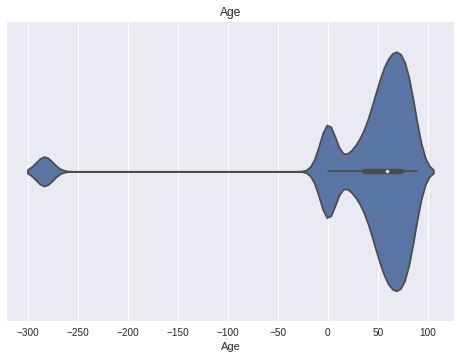

In [9]:
plotter.plot_violin(subset = ["Age"],inner = 'box')

One thing we missed is to check for any incorrect values in the variables we calculated. The above plot shows a couple of people with negative ages. This could be due to incorrect recording of date of birth. We can filter out such records. 

In [0]:
plotter.data = plotter.data[plotter.data.Age>=0]

Let's plot the graph again and see now

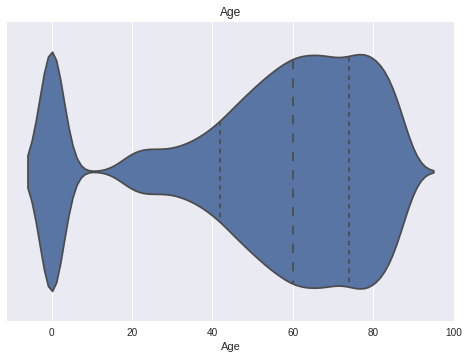

In [11]:
plotter.plot_violin(subset = ["Age"],inner='quartile')

To understand the frequency distribution, we can also use the histogram.

In [0]:
def plot_hist(self,subset = None,**args):
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.distplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_hist = plot_hist

And let's not ignore the box plot.

In [0]:
def plot_box(self,subset = None,**args):
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.boxplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_box = plot_box

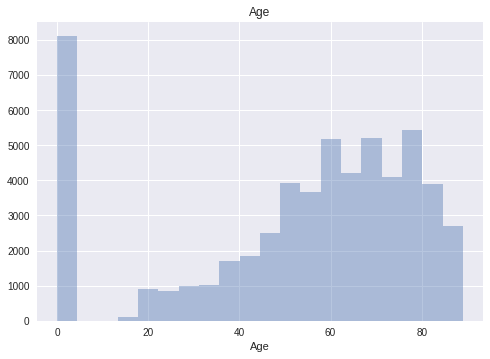

In [14]:
plotter.plot_hist(subset = ["Age"],kde = False,bins = 20)

Just as suggested by the violin plot, one main take away is that most of the patients are aged 50+(as suggested by the quartile ranges) and many are new borns.

Consider readmit.

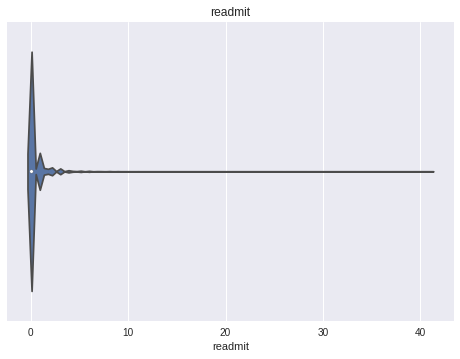

In [15]:
plotter.plot_violin(["readmit"])

There is an outlier that is making the violin plot look like this. Let's take a look at hte histogram for a better understanding.

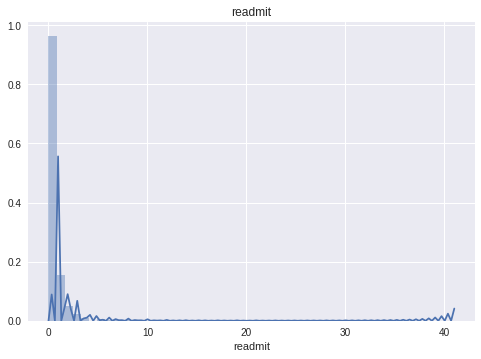

In [16]:
plotter.plot_hist(["readmit"],kde=True)

Since there is an outlier in our data, it can really throw off the results of the less robust statistical tests and models. We can either deal with this outlier or end up using only the robust statistical tests and hope regularisation takes care on the model front.
<br>
Instead, we can use a technique called winsorization. Winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. Let's go ahead and try winsorizing the data.

Text(0.5,1,'Readmits')

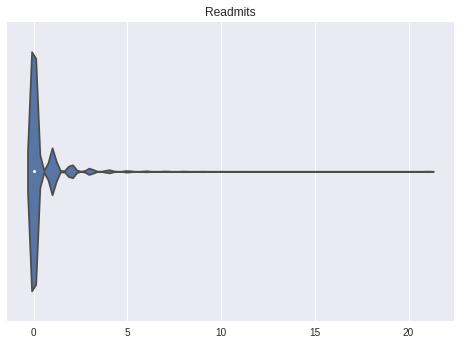

In [17]:
sns.violinplot(pd.Series(scipy.stats.mstats.winsorize(plotter.data.readmit,limits=(None,0.001))))
plt.title("Readmits")

The readmits columns basically contains the number of previous readmits and most of the patients have not been readmitted, hence the skew in the data. The plot above shows the result of winsorizing the data by trimming the right most 0.001% of the data in the plot.

Moving on to the length of stay.

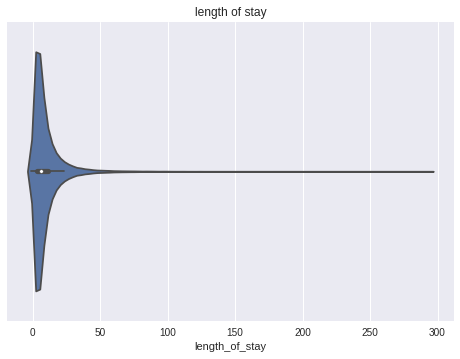

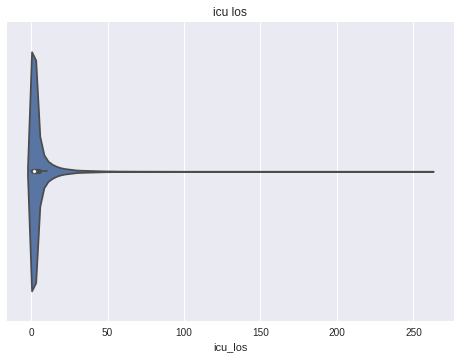

In [18]:
plotter.plot_violin(subset = ["length_of_stay","icu_los"])

As expected, the length of stay of most admits is less than 10-20 days. 

Consider Charlson Comorbidity index

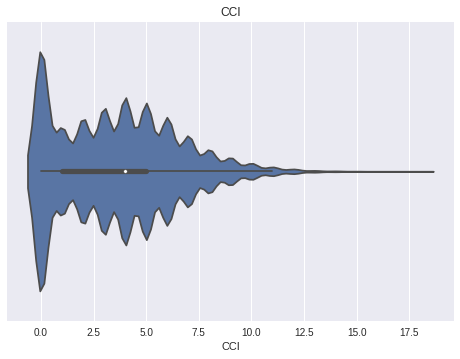

In [19]:
plotter.plot_violin(subset = ["CCI"])

Many of the patients have a comorbidity index of 0. However, since people over 40 years of age by default have a comorbidity value greater than 0, we can notice many values between 0 to 10.

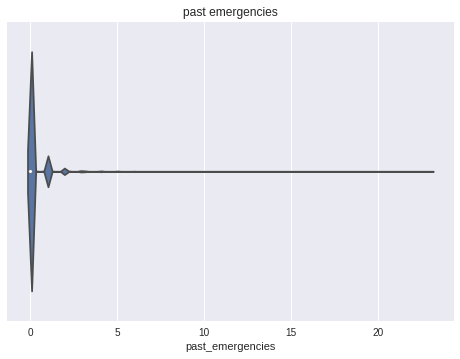

In [20]:
plotter.plot_violin(subset = ['past_emergencies'])

Very few people have had a past emergency readmit, however in some cases there are outliers.

Text(0.5,1,'Past Emergencies')

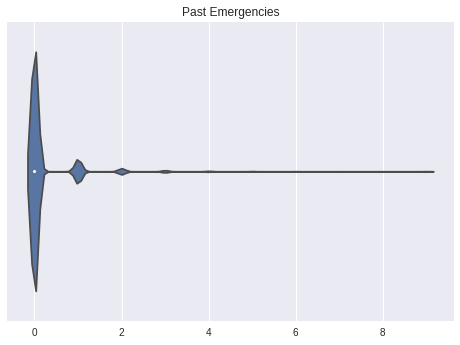

In [21]:
sns.violinplot(pd.Series(scipy.stats.mstats.winsorize(plotter.data.past_emergencies,limits=(None,0.001))))
plt.title("Past Emergencies")

Now let's consider the categorical data and their distribution. One of the most commonly used plot for categorical data is the bar plot. Let's add a function to plot bar plots into our plotter class

In [0]:
def plot_bar(self,subset = None,**args):
  if subset == None:
    columns_considered = self.categorical_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.barplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_bar = plot_bar

<a id='Bivariate'></a>
## Bivariate

<a id='Multivariate'></a>
## Multivariate

<a id='Data_modeling'></a>
# Data Modeling

<a id='Presentation'></a>
# Presentation